# Problem statement

In our problem I intend to solve the MNIST Digits Dataset.

The purpose of this Notebook is to show what is in the "behind the scenes" of Neural Newtwok, therefore **only Numpy** was used to solve it (no libraries such as TensorFlow, PyTorch), etc.

Since the exercise's purpose is just to show what happens during the "under the hood" of training neural networks and gradient descent, there are many things you could seek to improve (although we get very good results at the end) in which we do not get into much detail here.

Feel free to experiment with the Notebook and see what you could further do with it.


# Data Preprocessing

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import random
import pandas as pd

## Loading Dataset

*Note: The `fetch_openml()` function sometimes takes over a minute to excecute, so don't worry, just leave it running.*

In [2]:
mnist = fetch_openml("mnist_784")
x, y = mnist["data"].to_numpy(), mnist["target"].to_numpy().astype("int")
x.shape, y.shape

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


((70000, 784), (70000,))

Normalize `X` so that all values are betweeen 0 and 1. That means our network won't have to deal with very large values

In [3]:
x /= x.max()
x.min(), x.max()

(0.0, 1.0)

## Split into test and train sets

In [4]:
np.random.seed(42)
random.seed(42)

# randomly shuffle our dataset
ixs = np.arange(x.shape[0])
np.random.shuffle(ixs)
x, y = x[ixs].squeeze(), y[ixs].squeeze()
x.shape, y.shape

((70000, 784), (70000,))

In [5]:
train_split = 0.8  # 80% train
test_split = 0.1  # 10% test and dev (validation)

train_ix = int(train_split * x.shape[0])
test_ix = int(test_split * x.shape[0]) + train_ix

xtrain, ytrain = x[:train_ix], y[:train_ix]
xtest, ytest = x[train_ix:test_ix], y[train_ix:test_ix]
xval, yval = x[test_ix:], y[test_ix:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape, xval.shape, yval.shape

((56000, 784), (56000,), (7000, 784), (7000,), (7000, 784), (7000,))

## Utility function for visualization

What this function does is that it visualises random samples from train, test or all the datasets. It displays the digit each image represents and if we have a model with which we can make predictions, it displays true values against predictions too.

In [6]:
def visualise(nrows=5, ncols=5, split="all", model=None, figsize=(7, 7)):
    # decide which are our x and y
    if split == "all":
        vx, vy = x, y
    elif split == "train":
        vx, vy = xtrain, ytrain
    elif split == "val":
        vx, vy = xval, yval
    # I used elif on purpose, so we have an error if it is none of the keywords
    elif split == "test":
        vx, vy = xtest, ytest

    # turn preds and ys into strings to put in the label of the picture
    if model is not None:
        pred = model(vx).argmax(1)
        pred = [f"({i})" for i in pred]
    else:
        pred = ["" for i in range(vx.shape[0])]
    vy = [str(i) for i in vy]

    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    for i in range(nrows):
        for j in range(ncols):
            n = np.random.choice(vx.shape[0])  # randomly choose our image
            axs[i, j].tick_params(left=False, bottom=False,
                                  labelleft=False, labelbottom=False)
            axs[i, j].set_xlabel((vy[n] + pred[n]))
            m = int(vx.shape[1]**0.5)  # the width/height of the shape
            axs[i, j].imshow(vx[n].reshape((m, m)), cmap="gray");

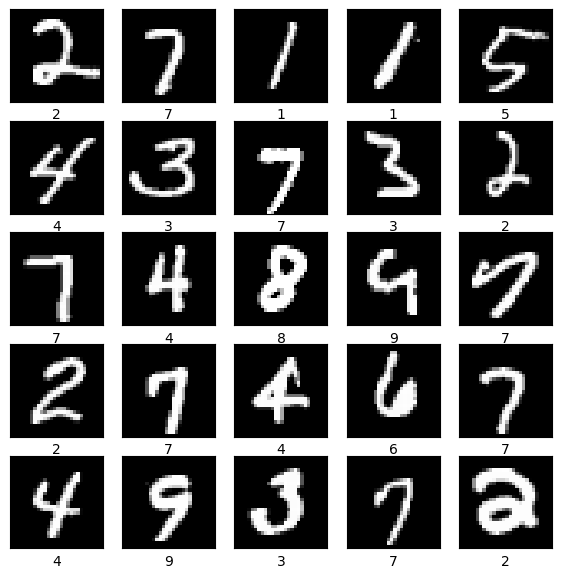

In [7]:
visualise()

# Building out the Neural Net

Since this purpose of this project is to show the "under the hood" of neural nets and backpropagation, we are going to use a fairly simple structure here:

1. Linear Layer
2. ReLU Layer
3. Linear Layer
4. Softmax Layer

## Building Out Layer Classes

We will be building classes for layers just like in libraries such as PyTorch or TensorFlow. We could do function-oriented too, but since the purpose of the notebook is to imitate PyTorch and Tensorflow we follow the same method as them, so an object-oriented design. In addition, having classes for layers makes the code more readable and makes it easier to stack layers one over the other

### Linear Layer

Just a simple linear layer that applies a linear transformation to an input `x`. At initialization random weights and biases are assigned. These are multiplied by `0.1` so that we do not have a big initial loss (ideally we would use Kaiming Inititialization here, but this Notebook does not get into that much detail).

When the layer is called, the linear transformation is applied.

We also have a function `backprop()` which finds out the gradients through derivation and applies them to the parameters (weights and biases) by adding the learning rate

In [8]:
class Linear:

    def __init__(self, input, output):
        # initialize weights and biases and "squash them down"
        self.weights = np.random.normal(size=(input, output)) * 0.1
        self.biases = np.random.normal(size=(output,)) * 0.1

    def __call__(self, x):
        # apply linear transformation during forward pass
        self.inp = x
        self.out = x @ self.weights + self.biases
        return self.out

    def backprop(self, dout, lr):
        x = self.inp

        # calculate the gradients
        dx = dout @ self.weights.T
        dweights = x.T @ dout
        dbiases = dout.sum(0)

        # adjust weights and biases accordingly
        self.weights += -lr * dweights
        self.biases += -lr * dbiases

        # return the gradient of x as it might be needed further on
        return dx

### ReLU Layer

Just a simple Rectified Linear Unit. During the forward pass it just zeroes out negative values. During the backward pass with `backprop` we just find out the values of the gradients. They are 1 in positive number and 0 in 0 and negative numbers. We do not update any parameters as ReLU layers don't have any

In [9]:
class ReLU:

    def __call__(self, x):
        self.inp = x
        self.out = np.maximum(x, np.zeros_like(x))
        return self.out

    # we don't need lr here, it just makes it easier when looping through layers
    def backprop(self, dout, lr):
        x = self.inp

        # find out the gradients of the values that flow through
        dx = dout * (x > 0).astype("float64")

        # return the gradient
        return dx

### SoftMax layer

The Classical Softmax layer that takes in some logits and turns them into probabilities. The `backprop()` function finds the gradient of the logits, given the gradient of the probabilities.

In [10]:
class Softmax:

    def __call__(self, logits):
        self.inp = logits

        exps = np.exp(logits)  # exponentiate the logits to get numbers above 0
        sums = np.sum(exps, axis=1, keepdims=True)  # sum of these exponents
        # divide the exponentials with the sum to get probability-like values
        probs = exps / sums  # just like out in other layers

        self.out = probs
        return self.out # return probabilities

    # we don't need lr here, it just makes it easier when looping through layers
    def backprop(self, dprobs, lr):
        logits = self.inp

        exps = np.exp(logits)  # exponentiate the logits to get numbers above 0
        sums = np.sum(exps, axis=1, keepdims=True)  # sum of these exponents

        dexps = dprobs / sums  # 1 / sums since it is divided by it, chain rule with dprobs
        # apply derivation rule then add across row
        dsums = np.sum((dprobs * -exps * sums**-2), axis=1, keepdims=True)
        dexps += 1 * dsums  # gradient 1 in contribute to sum, apply chain rule
        dlogits = dexps * exps  # local derivative is the exponential function

        return dlogits  # return the found derivative

### Sequential Layer

A Sequential model template just like in TensorFlow or PyTorch. It is a container for all of our other layers. It does the forward and backward passes automatically for each layer

In [11]:
class Sequential:

    def __init__(self, layers):
        self.layers = layers  # all the layers that are in our model

    def __call__(self, x):
        self.inp = x

        # go through every layer and modify our x in each of them
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out  # return our modified x

    def backprop(self, dout, lr):
        for layer in self.layers[::-1]:
            dout = layer.backprop(dout, lr)

        return dout

## Initializing our Neural Net

In [12]:
n_hidden = 10  # number of neurons on the hidden layers
T = x.shape[1]  # time (pixels in our case). The dimensions for images are B, T, C
n_classes = len(np.unique(y))  # number of classes (10 in our case)

Here we initialize our model and its layers. Only linear layers take parameters. As we can see, the input dimension of the first layer is `T` (time) which are pixels in our case. This layer has `n_hidden` neurons, the arbitrary parameter we decided above. Then the the second layer takes `n_hidden` as input and outputs `n_classes` which is 10 in our case, so as to give probabilities for each class

In [13]:
model = Sequential([
    Linear(T, n_hidden), ReLU(), Linear(n_hidden, n_classes), Softmax()
])

## Training

### Functions used during training

#### Accuracy check

A pretty basic function that just gives accuracy

In [14]:
def accuracy(X, Y, model):
    preds = model(X).argmax(1)
    acc = (preds == Y).astype("int").sum() / Y.shape[0]
    return acc

#### Function for log probabilities

This function calculates the log probabilities of our softmax. We will be needing it for the loss below

In [15]:
# function to find logprobs of a given X
def logprobs(X, model):
    probs = model(X)  # pass our x through our model to get our probabilities
    n = probs.shape[0]  # number of samples

    # find and return logprobs
    logprobs = np.log(probs)
    return logprobs

#### Loss

The loss we use here is negative log likelihood, otherwise known as cross entropy. We have two functions here, one that forward propagates to find the loss, and one that backpropagates from the loss

In [16]:
def cross_entropy(X, Y, model):  # find the cross entropy loss for our model
    logs = logprobs(X, model)
    # at each sample get the loss according to the target for that sample
    n = logs.shape[0]
    loss = -logs[range(n), Y].mean()  # get the mean negative log likelihood

    return loss

In [17]:
def cross_entropy_backprop(X, Y, model, lr):
    probs = model(X)  # pass our x through our model to get our probabilities
    n = probs.shape[0]  # number of samples
    logprobs = np.log(probs)  # find logprobs
    dlogprobs = np.zeros_like(logprobs)  # all are 0 initially
    dlogprobs[range(n), Y] = -1 / n  # the ones calculated in the mean
    dprobs = dlogprobs * (1 / probs)  # apply the derivative of the log

    model.backprop(dprobs, lr)

### Training Loop

The hyperparameters below are fairly arbitrary and I've found out that they work well. However, feel free to change and play around with them.

In [18]:
# hyperparameters
B = 1024 # batch size
lr = 0.1  # learning rate
epochs = 25 # number of epochs we train for

In [19]:
# statistics to plot later
train_accs, val_accs, train_losses, val_losses = [], [], [], []

In [20]:
print("                          Acc | Loss")
for i in range(epochs):  # number of epochs we will train for
    # take a look at every batch
    for j in range(0, xtrain.shape[0], B):
        # define xb and yb, x-batch and y-batch
        xb = xtrain[j:] if xtrain.shape[0] - j < B else xtrain[j:j+B]
        yb = ytrain[j:] if ytrain.shape[0] - j < B else ytrain[j:j+B]

        # do the forward and backward passes
        cross_entropy_backprop(xb, yb, model, lr)
    # keep track of the statistics
    train_acc, val_acc = accuracy(xtrain, ytrain, model), accuracy(xval, yval, model)
    train_loss = cross_entropy(xtrain, ytrain, model)
    val_loss = cross_entropy(xval, yval, model)

    # append stats to outer arrays
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (i+1) % 5 == 0:
        print(f"{i+1:02}) train: {train_acc*100:05.2f}% val: {val_acc*100:.2f}% | train: {train_loss:.4f} val: {val_loss:.4f} ")

                          Acc | Loss
05) train: 86.76% val: 87.16% | train: 0.4661 val: 0.4537 
10) train: 89.48% val: 89.53% | train: 0.3698 val: 0.3594 
15) train: 90.48% val: 90.71% | train: 0.3353 val: 0.3270 
20) train: 91.11% val: 90.97% | train: 0.3154 val: 0.3090 
25) train: 91.50% val: 91.37% | train: 0.3013 val: 0.2967 


# Testing and Evaluating

## Plotting the accuracy and loss curves

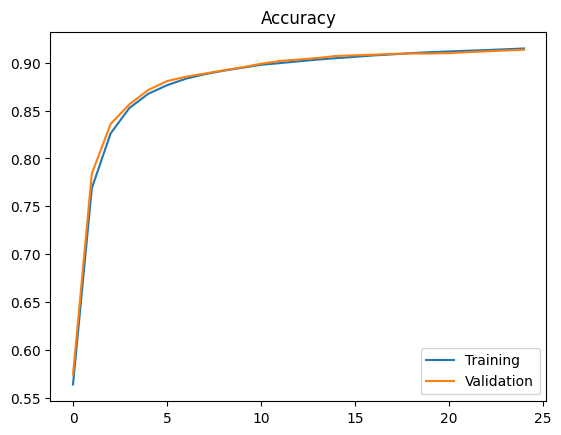

In [21]:
plt.plot(train_accs, label="Training")
plt.plot(val_accs, label="Validation")
plt.title("Accuracy")
plt.legend()
plt.show();

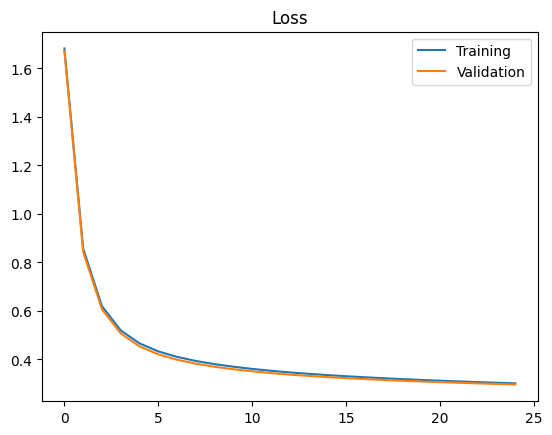

In [22]:
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show();

The graphs above show that the loss and accuracy flatten out after a certain period, meaning that it would not have much of a benefit training for longer. In addition, validation and training statistics are similar, which means we don't have any overfitting

## Performance on the test set

As we can see, the statistics are pretty good. Can you push them further?

In [23]:
test_acc = accuracy(xtest, ytest, model)
test_loss = cross_entropy(xtest, ytest, model)
test_acc, test_loss

(0.9055714285714286, 0.3194039379973841)

### Comparing with train and validation sets

Let's find out the statistics for the train and validation tests too and plot them out against the test stats

In [24]:
train_acc = accuracy(xtrain, ytrain, model)
train_loss = cross_entropy(xtrain, ytrain, model)
train_acc, train_loss

(0.9149821428571429, 0.3013232675400894)

In [25]:
val_acc = accuracy(xval, yval, model)
val_loss = cross_entropy(xval, yval, model)
val_acc, val_loss

(0.9137142857142857, 0.29667524095293746)

In [26]:
bins = ["Training set", "Validation set", "Testing set"]

In [27]:
accs = [train_acc, val_acc, test_acc]
losses = [train_loss, val_loss, test_loss]

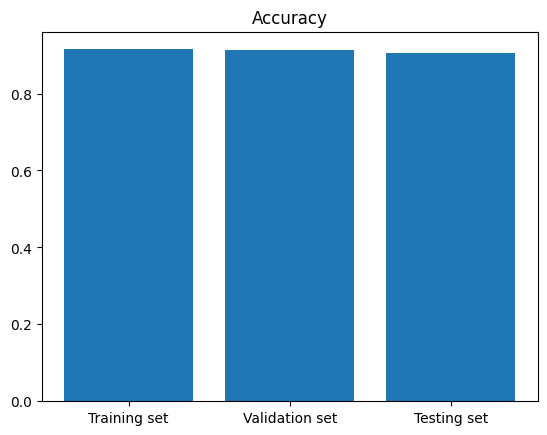

In [28]:
plt.bar(bins, accs)
plt.title("Accuracy")
plt.show();

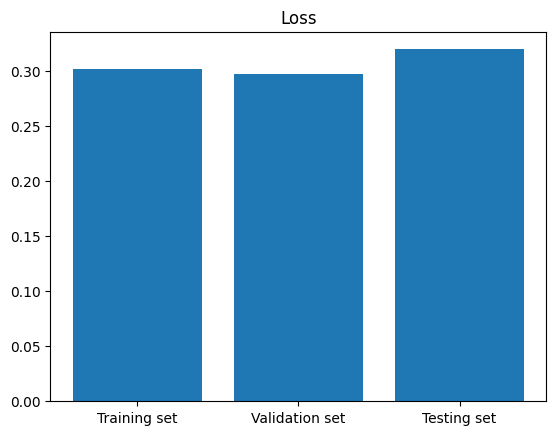

In [29]:
plt.bar(bins, losses)
plt.title("Loss")
plt.show();

## Vizualising results

Let's visualise our results using the `visualise()` function that we built out earlier. Here I am visualising 100 samples, so as to confirm the test accuracy we found out earlier

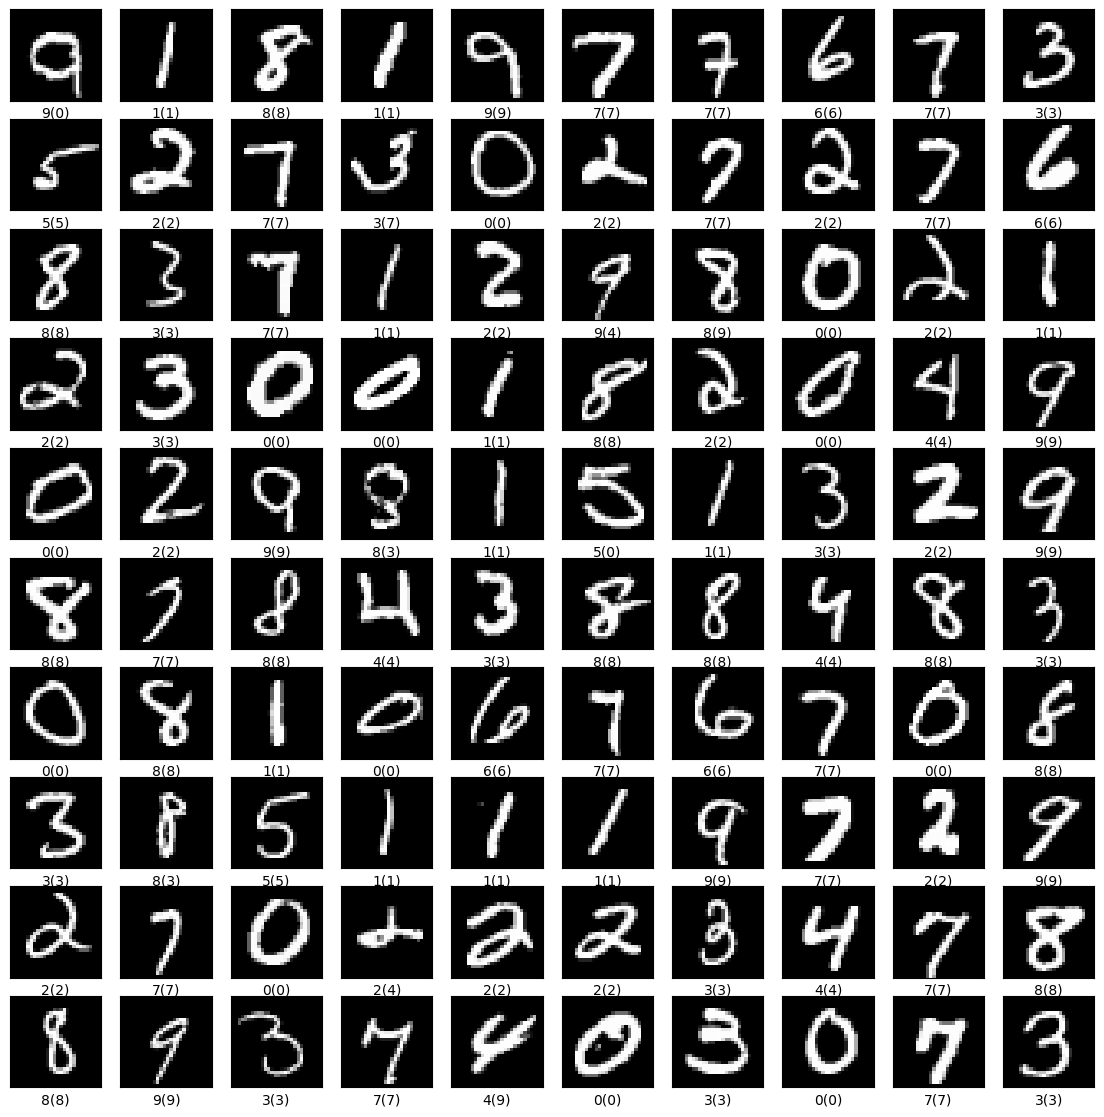

In [30]:
visualise(nrows=10, ncols=10, model=model, split="test", figsize=(14, 14))